In [1]:
from dotenv import load_dotenv, find_dotenv
import os 
from langgraph.prebuilt import create_react_agent
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma
from langchain.chains import ConversationalRetrievalChain,load_summarize_chain
from langchain.memory import ConversationBufferMemory
from langchain_openai import ChatOpenAI
from langchain.document_loaders import UnstructuredExcelLoader,PyPDFLoader
from langgraph_supervisor import create_supervisor
from langchain.chat_models import init_chat_model
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_core.messages import convert_to_messages

load_dotenv(find_dotenv(), override=True)

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

llm_openai = ChatOpenAI(model="gpt-4-turbo-2024-04-09",temperature=0.1)

memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True,output_key='answer')

credit_policy_vector_store = Chroma(
    collection_name="credit_policy_collection",
    embedding_function=embeddings,
    persist_directory="./credit_policy_db",
)

/var/folders/66/z_b55kvs5xxbskrymwm96gm00000gn/T/ipykernel_47766/3562069368.py:21: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True,output_key='answer')


In [2]:
def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)

def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

In [3]:
def credit_risk_evaluation(emirates_id:str):

    """ Looks up the credit risk policies. """
    
    credit_report_file_path = f"credit-reports/{emirates_id}.pdf"
    loader = PyPDFLoader(credit_report_file_path)
    docs = loader.load_and_split()
    
    chain = load_summarize_chain(llm_openai, chain_type="stuff",verbose=False)
    
    summary = chain.invoke(docs)
    final_summary = summary['output_text']

    query = f"""
        Given the below summary of the credit report of an applicant, check whether the applicant 
        is elligible  for financial support given the credit policy rules. 
        
        Credit report Summary: 
        {final_summary} \n\n        
        """
    
    retriever = credit_policy_vector_store.as_retriever(
        search_type="mmr", search_kwargs={"k": 1, "fetch_k":2}
    )

    conversational_retrieval = ConversationalRetrievalChain.from_llm(
        llm=llm_openai,retriever=retriever, memory=memory,verbose=False
    )
    return conversational_retrieval.invoke(query)["answer"]

credit_risk_evaluator_agent = create_react_agent(
    model=llm_openai,
    tools=[credit_risk_evaluation],
    prompt=(
        "You are a Credit Risk Evaluation Agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Your job is to assess whether the applicant's credit report violates any financial support policies.\n"
        "- Use the available tools to retrieve and analyze relevant credit policy documents.\n"
        "- Extract matching policies or clauses using semantic search and base your evaluation on those.\n"
        "- Respond with ONLY the compliance result, the matched policies, and your risk assessment.\n"
        "- DO NOT explain your reasoning or add extra commentary.\n"
        "- Once your analysis is complete, send the structured result back to the supervisor.\n\n"
        "Your final output must only contain the following attributes:\n"
        "  credit_risk: \"High\" or \"Low\",\n"
        "  policy_matches: [\"DTI >=<number>\"],\n"
        "  compliance_flag: true or false"
    ),
    name="credit_risk_evaluator"
)

In [4]:
def summarize_bank_statements(emirates_id:str):
    """
    Summarizes the bank statements of the applicants
    """

    query = "Summarize the bank statement with key points and not more than 400 characters highlighting the key factors that will contribute to the applicants economic support plan."
    
    bank_statement_path = f"bank-statements/{emirates_id}.xlsx"
    loader = UnstructuredExcelLoader(bank_statement_path)
    
    bank_statement_docs = loader.load()
    
    bank_statements_vector_store = InMemoryVectorStore(embeddings)
    bank_statements_vector_store.add_documents(documents=bank_statement_docs)

    bank_statement_retriever = bank_statements_vector_store.as_retriever(
        search_type="mmr",
        search_kwargs={"k": 1, "fetch_k": 2, "lambda_mult": 0.5},
    )
    conversational_retrieval = ConversationalRetrievalChain.from_llm(
        llm=llm_openai,retriever=bank_statement_retriever, memory=memory,verbose=False
    )

    return conversational_retrieval.invoke(query)["answer"]

financial_burden_agent = create_react_agent(
    model=llm_openai,
    tools=[summarize_bank_statements],
    prompt=(
        "You are a Financial Hardship Assessment Agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Your job is to calculate the applicant’s true financial hardship based on their income, liabilities, and number of dependents.\n"
        "- Use the available tools to retrieve and summarize the applicant’s bank statements, loan obligations, and dependent count.\n"
        "- Compute key metrics: debt-to-income ratio, monthly disposable income after liabilities, and per-dependent allocation.\n"
        "- Respond with ONLY a JSON object containing these metrics and an overall hardship classification (High, Moderate, Low).\n"
        "- Your final JSON must include exactly the following fields:\n"
        "  net_worth,\n"
        "  debt_to_income,\n"
        "  burden_score\n"
        "- Do NOT include any other keys, explanations, or commentary.\n"
        "- Return the structured result back to the supervisor when complete."
    ),
    name="financial_burden_evaluator"
)


In [5]:
social_support_supervisor = create_supervisor(
    model=llm_openai,
    agents=[financial_burden_agent, credit_risk_evaluator_agent],
    prompt=(
        "You are the Social Support Application Supervisor.\n"
        "Manage two agents:\n"
        "- financial_burden_agent: calculates true financial hardship and returns JSON with net_worth, debt_to_income, burden_score.\n"
        "- credit_risk_evaluator_agent: evaluates credit risk and returns JSON with credit_risk, policy_matches, compliance_flag.\n\n"
        "When a user query arrives:\n"
        "  1. Delegate to the appropriate agent (only one agent per request).\n"
        "  2. After you receive that agent’s output, use both sets of attributes to derive the final recommendation.\n\n"
        "Final decision logic examples:\n"
        "- If credit_risk is \"Low\" AND debt_to_income < 0.5 AND burden_score < 0.5 AND compliance_flag is true → Approved\n"
        "- If credit_risk is \"High\" OR debt_to_income > 0.8 OR burden_score > 0.8 OR compliance_flag is false → Soft Decline\n"
        "- Otherwise → Approved with Conditions\n\n"
        "Respond with ONLY a JSON object containing:\n"
        "  financial_support_decision: \"Approved\" | \"Soft Decline\" | \"Approved with Conditions\",\n"
        "  reason: a brief phrase like \"Low burden and acceptable credit\" or \"High debt-to-income ratio\"\n"
    ),
    add_handoff_back_messages=True,
    output_mode="full_history",
).compile()

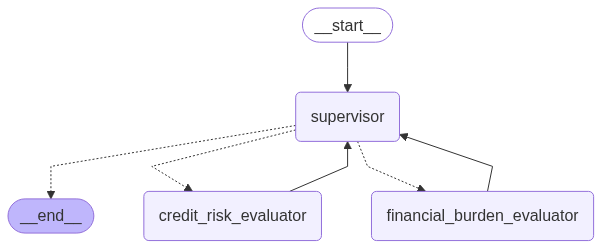

In [6]:
from IPython.display import display, Image

display(Image(social_support_supervisor.get_graph().draw_mermaid_png()))

In [7]:
emirates_id = "1234"
applicant_data = {
    "CurrentlyEmployed": "No",
    "last_drawn_salary": "12000 AED",
    "last_employment_date": "05-10-2024",
    "marital_status": "Yes",
    "num_children": 3
}

query = f"""
        Applicant Emirates ID: {emirates_id}. Here is their data: {applicant_data}. "
        """

response = social_support_supervisor.invoke(
    {
        "messages": [
            {"role": "user", "content": query}
        ]
    },
    {"recursion_limit": 10}
)

# print("Response keys:", response.keys())

history = response["messages"]  

last_msg = history[-1]  

if hasattr(last_msg, "content"):
    final = last_msg.content
else:
    final = last_msg["content"]

print(final)

{
  "financial_support_decision": "Soft Decline",
  "reason": "High debt-to-income ratio"
}
